<a href="https://colab.research.google.com/github/HarshithaNunna/Emocare/blob/main/Emocare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install shap==0.39.0
!pip install seaborn matplotlib scikit-learn


In [ ]:
# Required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import shap

In [ ]:
# Load dataset
df = pd.read_csv("Detection.csv")

In [ ]:
# Drop null values
df.dropna(inplace=True)

In [ ]:
# Encode the labels
le = LabelEncoder()
df['EMOTIONAL AFFIRM'] = le.fit_transform(df['EMOTIONAL AFFIRM'])


In [ ]:
# Normalize the features
scaler = StandardScaler()
X = df.drop(['Computer Time', 'EMOTIONAL AFFIRM'], axis=1)
X_scaled = scaler.fit_transform(X)

In [ ]:
# Convert labels to categorical (one-hot encoding)
y = to_categorical(df['EMOTIONAL AFFIRM'])


In [ ]:
# Reshape the input for LSTM [samples, time steps, features]
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Prevent overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=y.shape[1], activation='softmax'))  # Output units for each emotion

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7533 - loss: 1.0997 - val_accuracy: 0.8716 - val_loss: 0.3477
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9021 - loss: 0.2907 - val_accuracy: 0.9599 - val_loss: 0.1329
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9467 - loss: 0.1409 - val_accuracy: 0.9804 - val_loss: 0.0795
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9552 - loss: 0.1075 - val_accuracy: 0.9933 - val_loss: 0.0580
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9687 - loss: 0.0787 - val_accuracy: 0.9890 - val_loss: 0.0530
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9702 - loss: 0.0734 - val_accuracy: 0.9804 - val_loss: 0.0497
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9736 - loss: 0.0648 - val_accuracy: 0.9957 - val_loss: 0.0381
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9782 - loss: 0.0578 - val_accur

In [ ]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [ ]:
# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


              precision    recall  f1-score   support

       ANGRY       0.97      0.95      0.96        39
       HAPPY       1.00      1.00      1.00      1609
     RELAXED       1.00      1.00      1.00       225
         SAD       1.00      1.00      1.00       222

    accuracy                           1.00      2095
   macro avg       0.99      0.99      0.99      2095
weighted avg       1.00      1.00      1.00      2095



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = le.classes_
cm_df = pd.DataFrame(cm, index=labels, columns=labels)


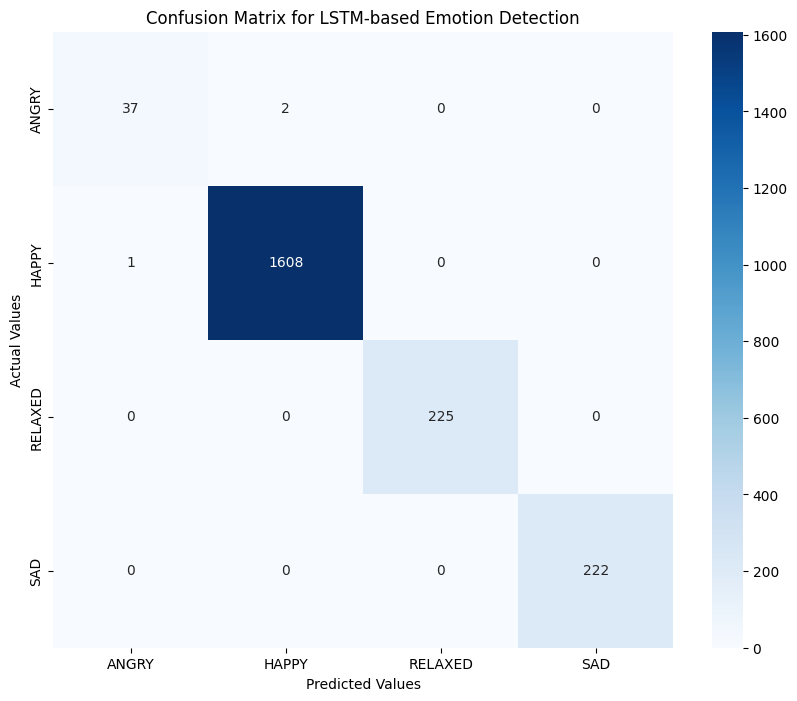

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.title('Confusion Matrix for LSTM-based Emotion Detection')
plt.show()

In [ ]:
# Check the shape of the LSTM model input
input_shape = X_train.shape  # It should be (samples, time steps, features)

In [ ]:
# Reshape the input data for SHAP
# Keep the time step dimension, typically 1 for LSTM (for univariate time series)
X_train_for_shap = X_train[:100].reshape(100, 1, 4)  # Reshape to (samples, time steps, features)

In [ ]:
# Create KernelExplainer with the reshaped data
explainer = shap.KernelExplainer(lambda x: model.predict(x), X_train_for_shap)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# --- SHAP Values ---

# Create a KernelExplainer with the correctly shaped data
explainer = shap.KernelExplainer(lambda : model.predict(x.reshape(x.shape[0], 1, 4)), X_train[:100]) # add a dimension to the input data for the prediction
x

Provided model function fails when applied to the provided data set.


TypeError: <lambda>() takes 0 positional arguments but 1 was given

In [ ]:
# Calculate SHAP values
shap_values = explainer.shap_values(X_test[:10].reshape(10, 4))


In [ ]:
# Calculate SHAP values
shap_values = explainer.shap_values(X_test[:10].reshape(10, 4))

# Convert the list of arrays to a single array
shap_values = np.array(shap_values).reshape(10,4)

# Plot SHAP values for the first prediction
shap.summary_plot(shap_values, X_test[:10].reshape(10, 4), feature_names=X.columns)
# shap_values is a list of arrays, access the first array using shap_values[0]